# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-wIzUAwxh-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 71093.96 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 101355.01 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 118335.98 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 133052.49 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 126689.49 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 72344.62 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 106976.25 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 127040.92 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 139419.57 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 142503.68 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 150028.13 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.91 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.70 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 38.16 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.83 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.77 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.30 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 54.85 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.16 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.76 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.34 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.53 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.99 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.07 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.56 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.97 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.02 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.76 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.58 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.13 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.02 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.46 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 35.89 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 41.92 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 45.28 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 47.90 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 47.81 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.16 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.59 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 27.66 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 34.90 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.45 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.19 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 34.08 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 38.73 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 42.99 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 44.69 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 44.42 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.42 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.67 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.95 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.17 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 51.35 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.72 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 53.83 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.79 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.66 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.82 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.93 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 37.86 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.24 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.38 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.62 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.32 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.90 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.48 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.54 examples/s]

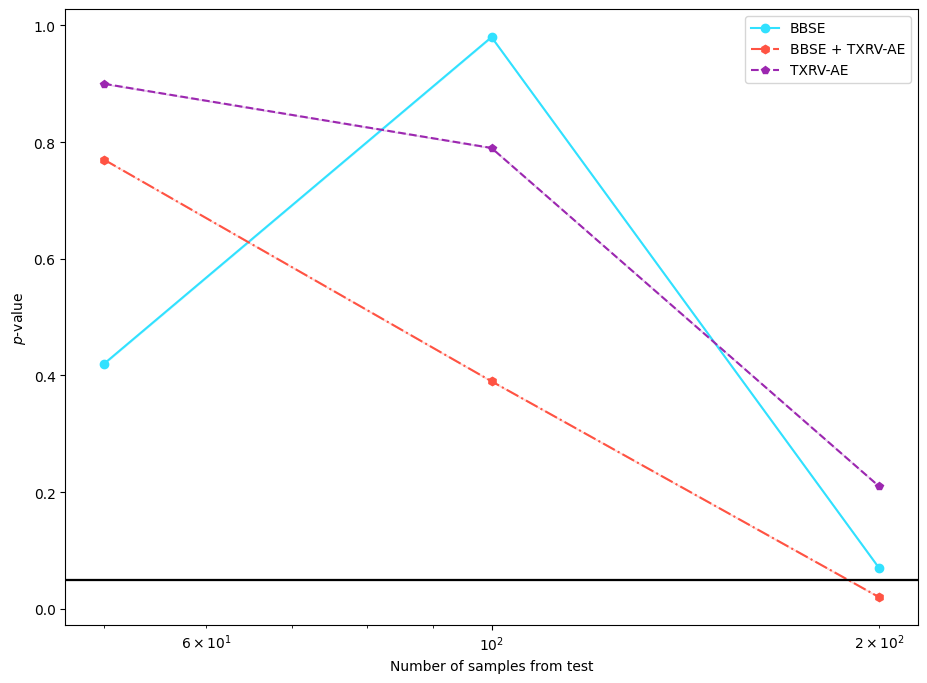

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.35 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.61 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.31 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.06 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.37 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.11 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.70 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.89 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.52 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.73 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 28.98 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 37.28 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.96 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.66 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.33 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.42 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.01 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.23 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.68 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.36 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.09 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.96 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.25 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.81 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.99 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.89 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.66 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.58 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.06 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.36 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.93 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.91 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.04 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 46.46 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.42 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.84 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.53 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.61 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.28 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.82 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.30 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.63 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.89 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.58 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.40 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.22 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.92 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.46 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.42 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.69 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.40 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.52 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.86 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.71 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.26 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.00 examples/s]

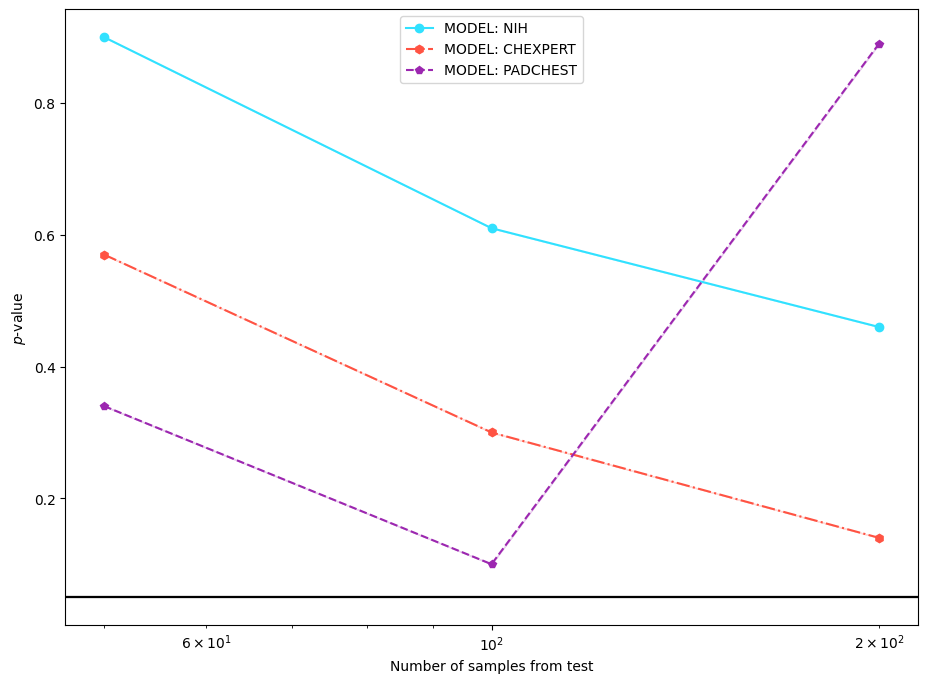

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 59545.72 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 85464.99 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 96630.13 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 104787.13 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 108164.68 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111959.93 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52389.69 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 78932.08 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94381.23 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 103802.45 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 110120.96 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 114773.09 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.26 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.70 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.24 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.65 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.12 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.79 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.49 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.36 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.49 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.73 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.10 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.38 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.19 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.96 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.41 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.84 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.53 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.51 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.21 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53601.72 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 75338.91 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90852.77 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 99840.85 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 110001.66 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 127080.03 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 50230.91 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72511.22 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 86761.68 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97711.87 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 105297.98 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111161.68 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.94 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.72 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.60 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.17 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.70 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.64 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.28 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.08 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.90 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.62 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.95 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.46 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.62 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.96 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.53 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.06 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.51 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.45 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56565.98 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81258.42 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94716.82 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 102805.61 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106643.55 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 115416.86 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 53079.08 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 78506.62 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 93084.94 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 100155.90 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 106578.59 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111552.67 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.05 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.40 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.28 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.41 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.50 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 57.25 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.59 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.77 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.52 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.11 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 27.98 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 36.58 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.89 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.71 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.69 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.68 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.28 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.41 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.91 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 56482.87 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 81003.26 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 94711.03 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 103375.68 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 107040.80 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 112609.92 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52300.06 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 77976.37 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 91691.67 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 103981.81 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 108820.80 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 112925.21 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.16 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.60 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.26 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.49 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.89 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.42 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.98 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.82 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.49 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.83 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.56 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.56 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.37 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.86 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.62 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.56 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.89 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.10 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.20 examples/s]

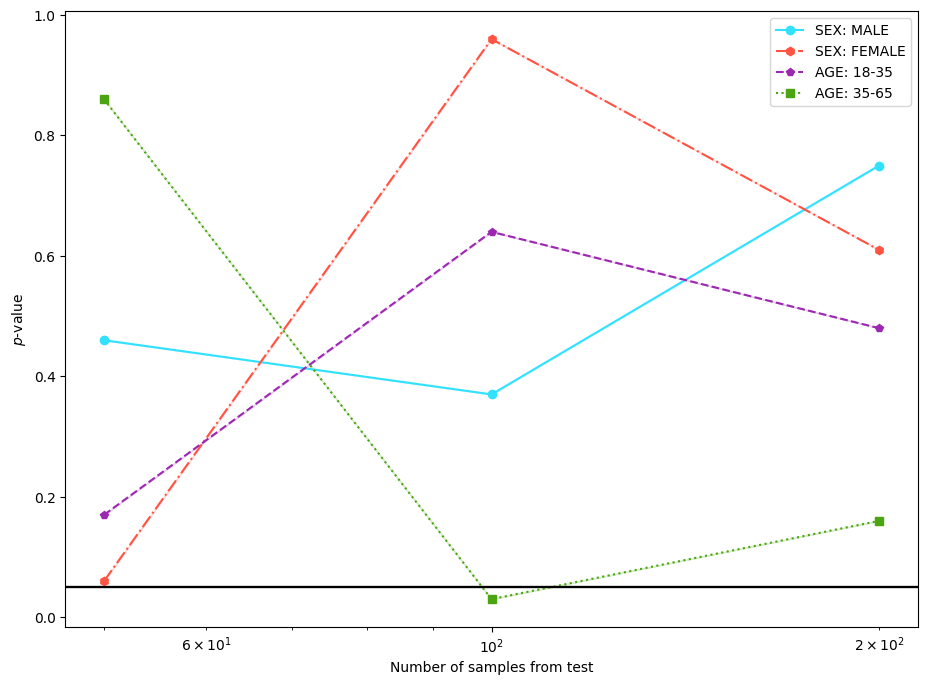

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.21 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.88 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.52 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.82 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.69 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.55 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.20 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.63 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.58 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.69 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.98 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.83 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.02 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.50 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.56 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.91 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.43 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.14 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.05 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.95 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.57 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.45 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.67 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.84 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 18.00 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.96 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.66 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.76 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.10 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.91 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.74 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.48 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.11 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.25 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.42 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.33 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.09 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.37 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.90 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.78 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.43 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.30 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.18 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.55 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.90 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.97 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.22 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.08 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.01 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.25 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.65 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.81 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.37 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.52 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.95 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.77 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.82 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.07 examples/s]

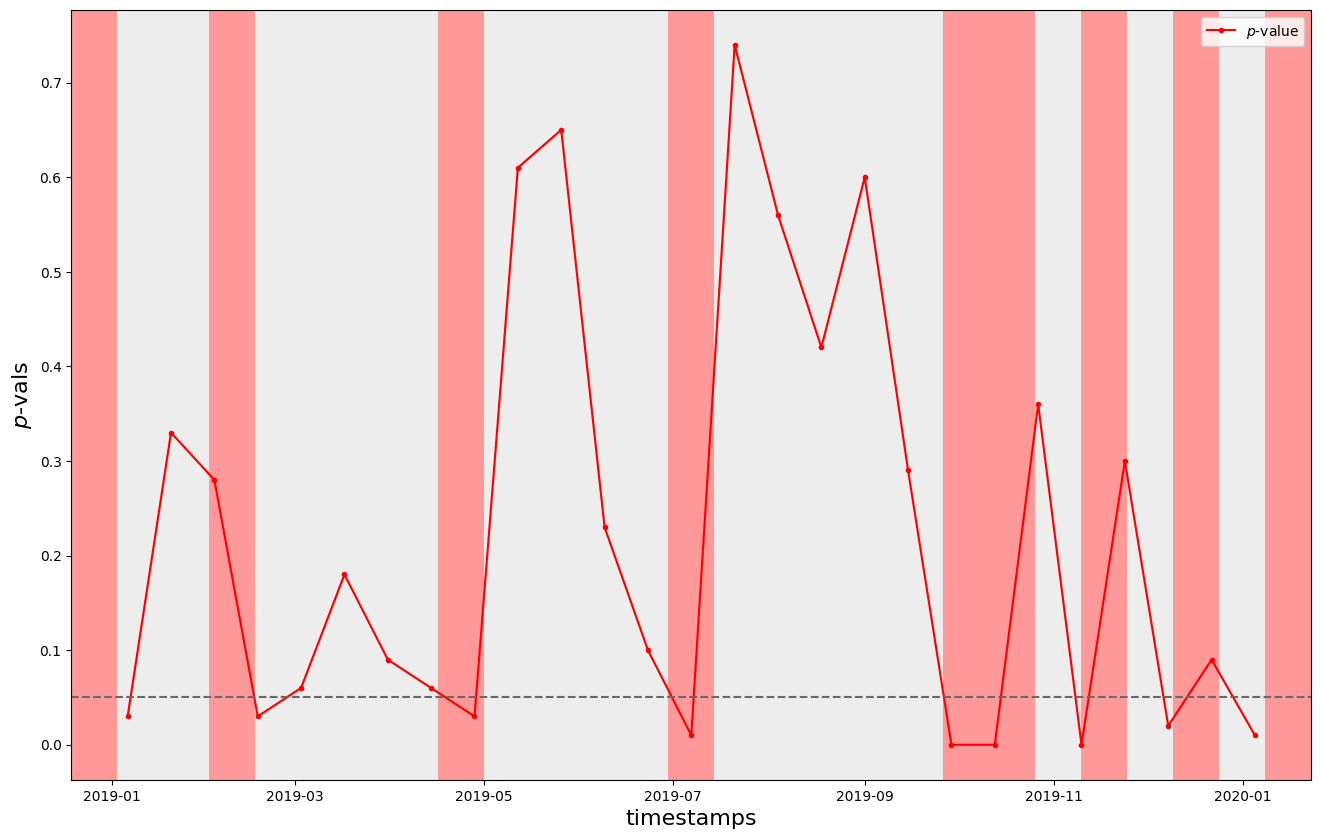

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)